In [1]:
import sys
sys.path.insert(0, '/Users/user/Documents/ecg_research/')

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib as jl
from savvyecg import ecg_utils
%matplotlib inline


In [163]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import wfdb as wf
import scipy.signal as ss
from sklearn.externals import joblib as jl
from biosppy.signals import ecg as ecgsig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import peakutils as pu
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from sklearn.metrics import confusion_matrix as cf

In [4]:
dat = "/Users/user/Downloads/incartdb/I01"
path = "/Users/user/physionet.org/physiobank/database/incartdb/"
sig, fields = wf.rdsamp(dat)
apn_temp = wf.rdann(dat, 'atr')

In [5]:
records = 'RECORDS'
records_arr = np.loadtxt(path + records, 'str')
records_arr = np.array([i[2:5] for i in records_arr])

In [6]:
records_arr

array(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18',
       'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27',
       'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36',
       'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45',
       'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54',
       'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63',
       'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72',
       'I73', 'I74', 'I75'], 
      dtype='<U3')

In [165]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
#     import matplotlib.pyplot as plt
#     import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(3.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[2.5,2.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([3.5,3.5],[-0.5,2.5], '-k', lw=2)
    
#     ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pred Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,3,
            'Sensitivity: %.2f'%(tp*1./(tp+fn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,3,
            'Specificity: %.2f'%(tn*1./(fp+tn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()
    print (tp*1./(tp+fn), tn*1./(fp+tn) )

In [7]:
t = .400 #seconds
f = 250 # sampling frequency
s = int(t * f)

# Load Data

In [91]:
ecgs_list, anns_list, labels_list = [], [] ,[]
patients_dict = {}
for i in records_arr: #load each patient's data
#     print i
    name = i
    sig, fields = wf.rdsamp(path + i)
    ann_temp = wf.rdann(path + i, 'atr')
#     ecg_temp = sig[:,-6] #V1
    ecg_temp = sig[:,1] #II
    ECG_bl = ecg_utils.baseline_correct(ecg_temp, 250) #baseline correct
    ECG_corr = ECG_bl #subtract baseline from ecg
    ann_idx = np.array(ann_temp[0][10:-10]) #annotation indices
    ann_label = np.array(ann_temp[1][10:-10]) #annotation labels
    windowed_beat = np.array([ECG_corr[i - s : i + s] for i in ann_idx]) #get shapes of each beat
    if np.mean([len(i) for i in windowed_beat]) == 2 * s:
        print (name)
        ecgs_list.append(windowed_beat) #store variables
        anns_list.append(ann_idx)
        labels_list.append(ann_label)
        patients_dict[name] = ecg_temp
    
    

I01
I02
I03
I05
I06
I07
I08
I09
I10
I11
I12
I13
I14
I15
I16
I18
I19
I20
I21
I22
I23
I24
I25
I26
I27
I28
I29
I30
I31
I32
I33
I34
I36
I37
I38
I39
I40
I41
I42
I43
I45
I46
I47
I48
I49
I50
I51
I52
I53
I54
I55
I56
I58
I59
I60
I61
I62
I63
I64
I65
I66
I67
I68
I69
I70
I71
I73
I75


In [92]:
ecgs_all = np.concatenate(ecgs_list)
idxs = np.concatenate(anns_list)
labels = np.concatenate(labels_list)

In [93]:
incartdb_dict = {'ECG':ecgs_all, 'Indices':idxs, 'Labels':labels}
jl.dump(incartdb_dict, '/Users/user/Documents/ecg_research/Databases/PAC_PVC_BBB_database.pickle')
jl.dump(patients_dict, '/Users/user/Documents/ecg_research/Databases/PAC_PVC_BBB_patients.pickle')

['/Users/user/Documents/ecg_research/Databases/PAC_PVC_BBB_patients.pickle']

In [8]:
# incartdb_dict = jl.load('/Users/user/Documents/ecg_research/Databases/PAC_PVC_BBB_database.pickle')

In [9]:
# ecgs_all = incartdb_dict['ECG']
# idxs = incartdb_dict['Indices']
# labels = incartdb_dict['Labels']

In [100]:
A_beats = ecgs_all[np.where(labels == 'N')]
A_anns = np.array(['N'] * len(A_beats))
normal_beats = ecgs_all[np.where(labels == 'A')]
normal_anns = np.array(['A'] * len(normal_beats))
R_beats = ecgs_all[np.where(labels == 'R')]
R_anns = np.array(['R'] * len(R_beats))
# S_beats = ecgs_all[np.where(labels == 'S')]
# S_anns = np.array(['S'] * len(S_beats))
V_beats = ecgs_all[np.where(labels == 'V')]
V_anns = np.array(['V'] * len(V_beats))



# Normal Beat

In [101]:
labels

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], 
      dtype='<U1')

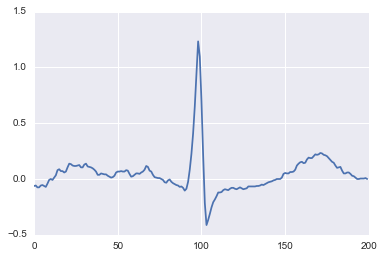

In [102]:
plt.plot(normal_beats[31])
plt.show()

# PAC Beat

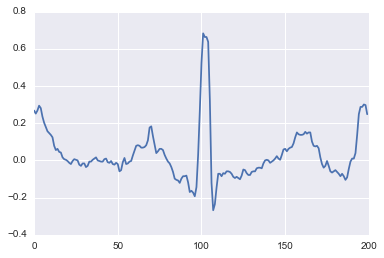

In [103]:
plt.plot(A_beats[100])
plt.show()

# BBBB Beat

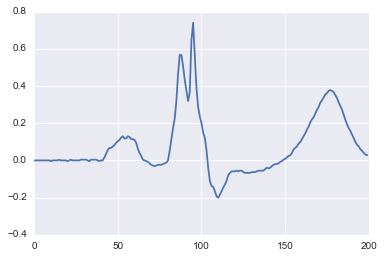

In [104]:
plt.plot(R_beats[14])
plt.show()

# PVC Beat

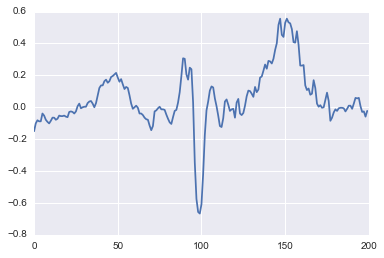

In [105]:
plt.plot(V_beats[5])
plt.show()

In [149]:
X = np.concatenate([normal_beats, A_beats, R_beats, V_beats]) #shape
y = np.concatenate([normal_anns, A_anns,  R_anns, V_anns])

In [150]:
y_bin = label_binarize(y, classes=['A', 'N','R', 'V']) #Normal, PAC, BBBB, PVC
n_classes = y_bin.shape[1]

In [151]:
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)

In [157]:
# X_c = StandardScaler().fit_transform(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_bin, test_size=.4, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Classify

In [158]:
gt = y_test

In [118]:
best_classifier = MLPClassifier((100, 100, 100))
best_classifier.fit(X_train, y_train)
score = best_classifier.score(X_test, y_test)
prediction = best_classifier.predict(X_test)


In [153]:
score

0.99290564831828709

In [123]:
jl.dump(best_classifier, '/Users/user/Documents/ecg_research/Classifiers/PAC_PVC_BBBB_Classifier.sav')

['/Users/user/Documents/ecg_research/Classifiers/PAC_PVC_BBBB_Classifier.sav']

# Precision - Recall Curves

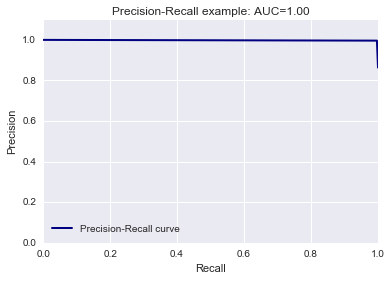

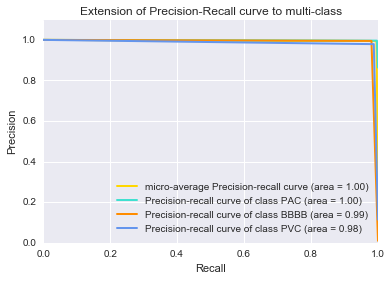

In [159]:
#plot details
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = cycle(['turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2
y_score = prediction
y_test = gt
y_test = y_test[:,[1,2,3]]
y_score = prediction[:,[1,2,3]]


# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes -1):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
list_names = ['PAC', 'BBBB', 'PVC']
for i, color in zip(range(n_classes-1), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(list_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

In [160]:
y_score = prediction
y_test = gt

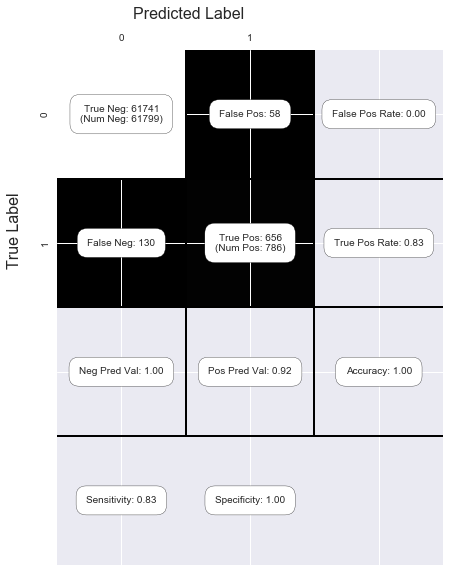

0.834605597964 0.999061473487


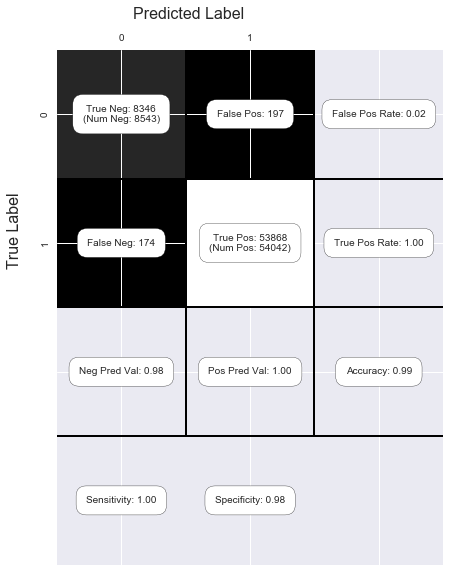

0.996780282003 0.976940184947


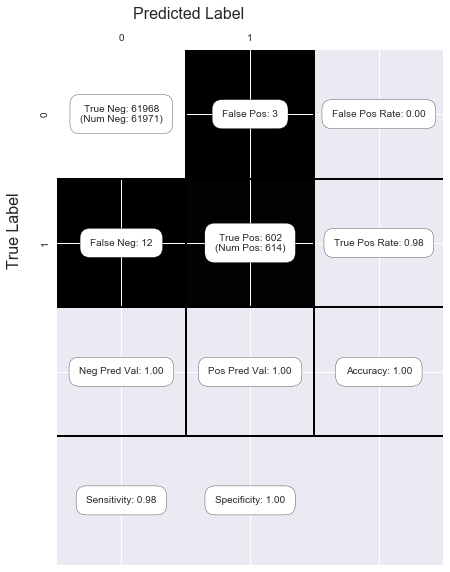

0.980456026059 0.99995159026


In [166]:
for i in range(n_classes - 1):
    show_confusion_matrix(cf(y_test[:,i], y_score[:,i]))
    